In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import f

**Setup**

**Setup**

*The F-Test is a statistical test for the hypothesis that two distributions have the same variance.*

Let $X_1,...,X_n$ iid $\sim \mathcal{N}(\mu_x, \sigma_x^2)$ and  $Y_1,...,Y_n$ iid $\sim \mathcal{N}(\mu_y, \sigma_y^2)$, with X and Y independent.

The null hypothesis is $H_0 : \sigma_x^2 / sigma_y^2 = 1$, ie. both distributions have the same variance.

Let

$
\begin{align*}
F_{XY} := \frac{S_x^2}{S_y^2}, F_{YX} := \frac{S_y^2}{S_x^2}
\end{align*}
$

where $S^2$ is the pooled unbiased sample variance, ie.

$
\begin{align*}
S_x^2 = \frac{1}{n-1}\sum_{i=1}^n(X_i - \bar{X})^2,\ \ \ S_y^2 = \frac{1}{m-1}\sum_{i=1}^m(Y_i - \bar{Y})^2.
\end{align*}
$

$n,m$ are the number of samples of $X$ and $Y$ respectively and, *if $X,Y$ are normally distributed*, then $Z$ follows an F-distribution with $n-1$ over $m-1$ degrees of freedom. If we want to test deviations in both directions (ie. $\sigma_x > \sigma_y or \sigma_y > \sigma_x$) we want a two-tailed test: We reject if $F < q_{sup}^F(\frac{\alpha}{2})$ or $F > q_{sup}^F(1-\frac{\alpha}{2})$.

To compute the p-value for a given sample, let $\bar{f} \geq 1$ be the ratio of the sample variances, taken such that the largest one is in the numerator, and let $n_n, n_d$ be the number of samples of the numerator and denominator samples respectively. Then, the p-value is

$
\begin{align*}
F(F > \bar{f}; n_n-1, n_d-1) + F(F < \frac{1}{\bar{f}}; n_d-1, n_n-1)
\end{align*}
$

To implement, I calculate the pivot and use cdf in `scipy.stats.f` to compute the p-value as described above.

In [2]:
N = (10**(np.arange(0.5,5,0.5))).round().astype(int)
Gamma = np.arange(0, 1, 0.1)
trials = 100
mu = 0
sigma_x = 1
sigma_y = 1
alpha = 0.05

print("SETUP\nno. of samples: %s" % N)
print("no. of trials for each sample size: %d" % trials)
print("X ~ N(%0.2f, %0.2f + gamma) with gamma in %s" % (mu, sigma_x, Gamma))
print("Y ~ N(%0.2f, %0.2f)" % (mu, sigma_y))

SETUP
no. of samples: [    3    10    32   100   316  1000  3162 10000 31623]
no. of trials for each sample size: 100
X ~ N(0.00, 1.00 + gamma) with gamma in [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Y ~ N(0.00, 1.00)


In [43]:
def ftest(X,Y,axis):
    alpha = 0.05
    """Return the pivot and p-value of the F-test for the given samples"""
    F = np.var(Y, axis, ddof=1) / np.var(X, axis, ddof=1)
    n = X.shape[1] - 1
    m = Y.shape[1] - 1
    # Test using critical values
    cl, cr = f.ppf(alpha/2, m, n), f.ppf(1-alpha/2, m, n)
    reject = np.logical_or(F < cl, F > cr)
    # Test using p-values
    p = f.cdf(F, m, n)
    p_value = 2 * np.minimum(p, 1-p)
    assert((reject == (p_value < alpha)).all())
    return F, p_value

/home/juan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/juan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/home/juan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWar

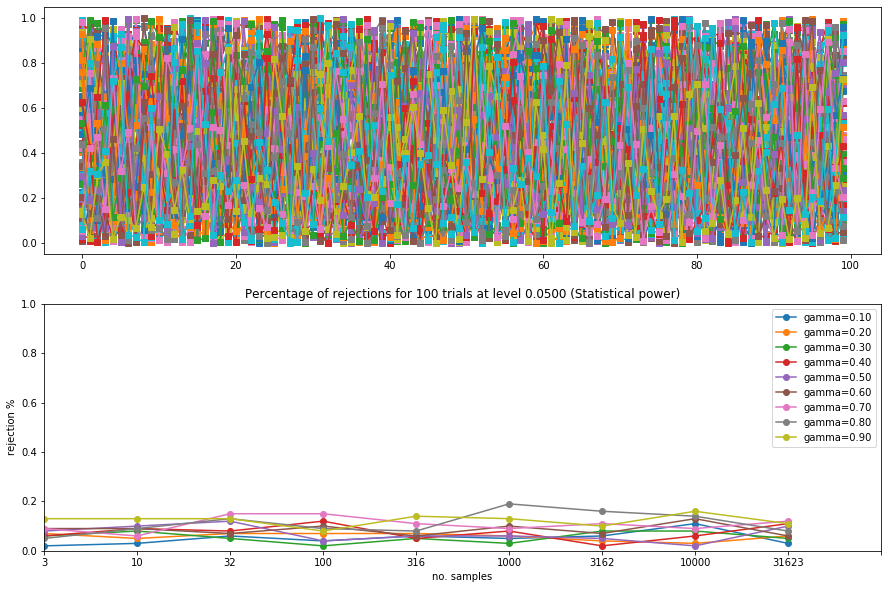

In [44]:
np.random.seed(42)
# Run tests and plot results
plt.figure(figsize = (15,10))
rejected = np.zeros((len(Gamma),len(N)))
for k,gamma in enumerate(Gamma):
    for i,n in enumerate(N):    
        X = np.random.normal(mu, sigma_x + gamma,size=(trials,5))
        Y = np.random.normal(mu, sigma_y, size=(trials,4))
        (_, p_value) = ftest(X, Y, axis=1)
        plt.subplot(211)
        plt.plot(p_value, "-s", label="%d samples" % n)
        rejected[k,i] = np.sum((p_value < alpha).astype(int)) / trials
        
    if gamma != 0:
        plt.subplot(212)
        plt.plot(rejected[k,:], '-o', label=("gamma=%0.2f" % gamma))

plt.subplot(212)
plot_meaning = "Statistical power"
plt.title("Percentage of rejections for %d trials at level %0.4f (%s)" % (trials, alpha, plot_meaning))
ax = plt.gca()
ax.set_xticklabels(N)
plt.axis([0, len(N), 0, 1])
plt.xlabel("no. samples")
plt.ylabel("rejection %")
plt.legend()

As expected, the closer the two variances are, the more samples are needed to reject the null hypothesis

**Testing one-trial implementation**

In [35]:
def f_test(X,Y):
    """Return the test statistic and p-value of the two sample g-test for
    the given sample"""
    X = X[np.isfinite(X)]
    Y = Y[np.isfinite(Y)]
    F = np.var(X, ddof=1) / np.var(Y, ddof=1)
    p = f.cdf(F, len(X)-1, len(Y)-1)
    return 2*min(p, 1-p)

/home/juan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/home/juan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


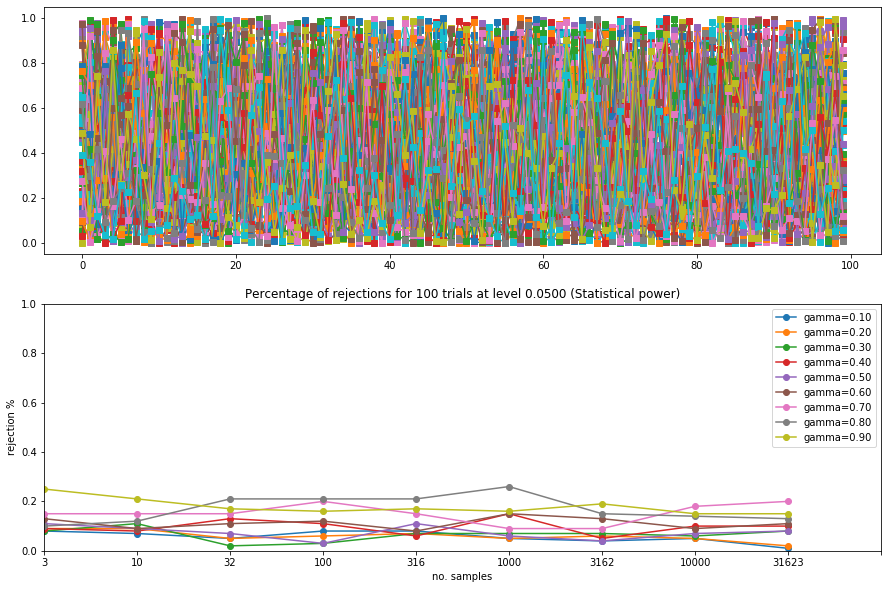

In [36]:
np.random.seed(42)
# Run tests and plot results
plt.figure(figsize = (15,10))
rejected = np.zeros((len(Gamma),len(N)))
for k,gamma in enumerate(Gamma):
    for i,n in enumerate(N):
        X = np.random.normal(mu, sigma_x + gamma,size=(trials,4))
        Y = np.random.normal(mu, sigma_y, size=(trials,5))
        rej_count = 0
        p_values = np.zeros(trials)
        for j in range(trials):
            p_value = f_test(X[j,:], Y[j,:])
            assert(p_value <= 1)
            p_values[j] = p_value
        rejected[k,i] = np.sum((p_values < alpha).astype(int)) / trials
        plt.subplot(211)
        plt.plot(p_values, "-s", label="%d samples" % n)
        
    if gamma != 0:
        plt.subplot(212)
        plt.plot(rejected[k,:], '-o', label=("gamma=%0.2f" % gamma))
        plot_meaning = "Statistical power"
        plt.title("Percentage of rejections for %d trials at level %0.4f (%s)" % (trials, alpha, plot_meaning))
        ax = plt.gca()
        ax.set_xticklabels(N)
        plt.axis([0, len(N), 0, 1])
        plt.xlabel("no. samples")
        plt.ylabel("rejection %")
        plt.legend()